In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# List of features for which CSVs are available.
features = [
    "AudioMAE",
    "CLAP",
    "HuBERT",
    "Wav2Vec2",
    "UniSpeech",
    "Whisper",
    "XVector",
    "MDuo",
]

# Container for each feature's dataframe.
dataframes = {}

# Read each CSV into a dataframe:
for feature in features:
    filename = f"../results/LibriSpeech_invariance/LibriSpeech_{feature}_AddReverb_feature_distances.csv"
    df = pd.read_csv(filename)
    dataframes[feature] = df

# Assume each CSV has the same 'transform_param' values.
common_x = dataframes[features[0]]["transform_param"]

# Build a dataframe with cosine similarity columns for all features.
cosine_df = pd.DataFrame(
    {feature: dataframes[feature]["cosine_similarity"] for feature in features}
)

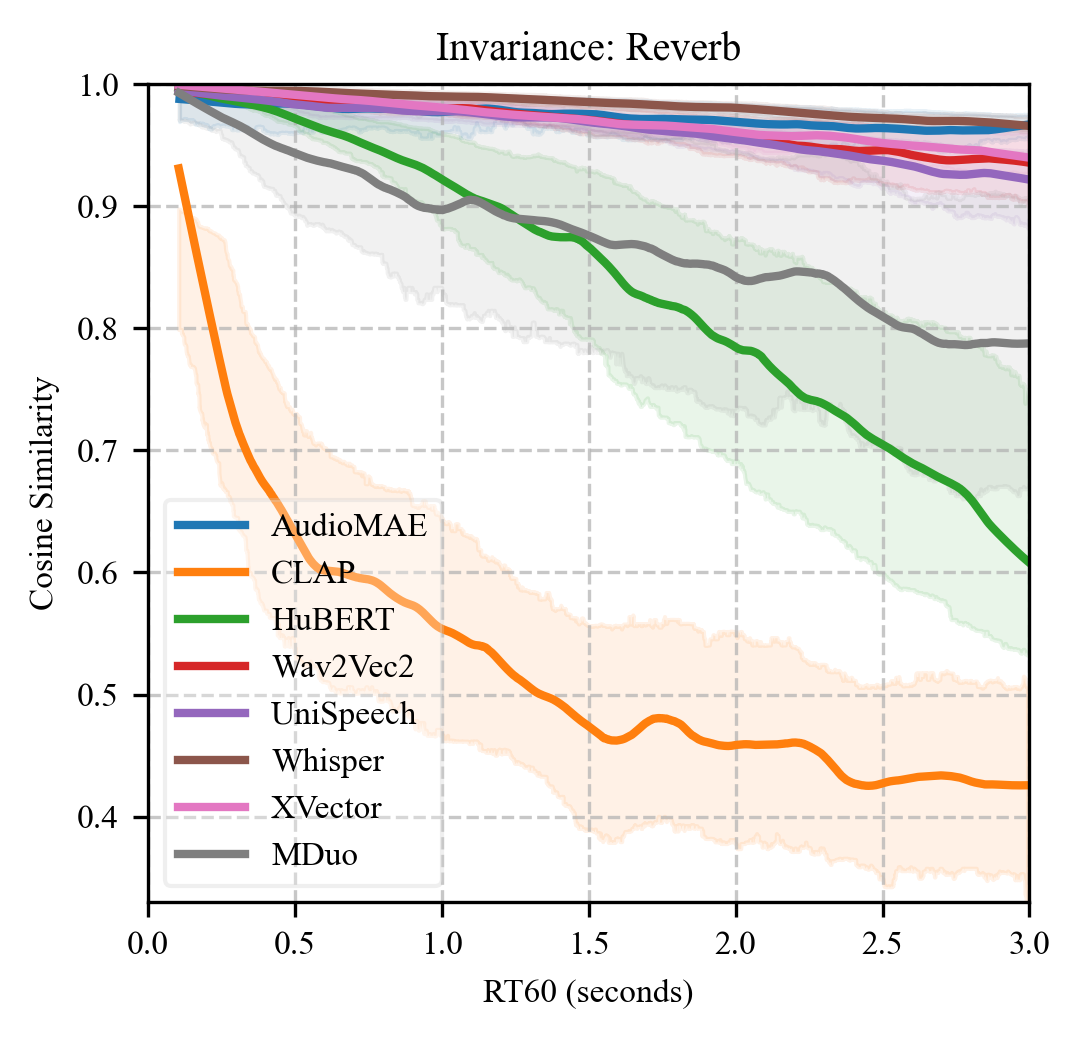

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from statsmodels.nonparametric.smoothers_lowess import lowess

plt.style.use(["default"])
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
        "font.size": 8,
        "figure.dpi": 300,  # Set display DPI
        "savefig.dpi": 300,  # Set save DPI
    }
)


def calculate_smoothed_curve(x, y, frac=0.1):
    """Calculate smoothed curve using LOWESS."""
    # Sort data by x values
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]

    # Apply LOWESS smoothing
    smoothed = lowess(y_sorted, x_sorted, frac=frac, it=1, return_sorted=False)

    return x_sorted, smoothed


def calculate_confidence_bands(x, y, window_size=0.1):
    """Calculate rolling quantiles for confidence bands."""
    df = pd.DataFrame({"x": x, "y": y})
    df = df.sort_values("x")

    # Calculate rolling quantiles
    rolling = df["y"].rolling(
        window=int(len(x) * window_size), center=True, min_periods=1
    )

    lower = rolling.quantile(0.25)
    upper = rolling.quantile(0.75)
    median = rolling.median()

    return df["x"], lower, median, upper


def create_invariance_plot(dataframes, features, smoothing_frac=0.1):
    """Create static plot with linear x-axis."""
    fig, ax = plt.subplots(figsize=(10 * 2.6 / 7.14, 3.5))
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    for feature, color in zip(features, colors):
        x = dataframes[feature]["transform_param"].values
        y = dataframes[feature]["cosine_similarity"].values

        # Calculate confidence bands
        x_sorted, lower, median, upper = calculate_confidence_bands(x, y)

        # Calculate smoothed curve
        _, smoothed = calculate_smoothed_curve(x, y, frac=smoothing_frac)

        # Plot
        ax.fill_between(x_sorted, lower, upper, alpha=0.1, color=color)
        ax.plot(
            x_sorted,
            smoothed,
            label=feature,
            color=color,
            linewidth=2,
        )

    ax.set_xlabel("RT60 (seconds)")
    ax.set_ylabel("Cosine Similarity")
    ax.set_title("Invariance: Reverb")
    ax.legend(loc="lower left", framealpha=0.3)
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.set_ylim(0.33, 1.0)
    ax.set_xlim(0, 3)
    ax.margins(x=0, y=0)
    plt.tight_layout()
    return fig, ax


# Create the interactive plot
fig, ax = create_invariance_plot(dataframes, features)
plt.show()